# Predicting Suicide Rates Using Linear Regression

In this notebook, we'll be using information such as country name, gender, age group, population count, GDP values, and other features to predict the suicide rate for a specific group of people at any given year. This kind of model is useful for suicide prevention and mental health hotline companies in terms of allowing them to figure out the trend in growth of this dilemma as well as in terms of monitoring their progress towards reducing these suicide rates. The dataset for this problem is taken from: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016

We will create a model with the following steps:
1. Downloading and Cleaning the Data
2. Exploring the Data
3. Preparing the Dataset for Training
4. Creating a Linear Regression Model
5. Training the Model to Fit the Data
6. Evaluating the Model on the Test Data

In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [3]:
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [4]:
project_name='02-custom-sucide-linear-regression' # will be used by jovian.commit

## Step 1: Downloading and Cleaning the Data 

To load the dataset into memory, we'll make use of the read_csv function from the Pandas library.We will then load the data as a Pandas dataframe.

In [5]:
dataframe = pd.read_csv('/kaggle/input/suicide-rates-overview-1985-to-2016/master.csv')

To clean the data, we first start by removing unnecessary columns such as **suicides_no**, **country-year**, and **generation** since these columns are simple transformations of other provided columns and do not provide any new information. We then relabel the **gdp_for_year (\$)** column since the original dataset has the string with an extra whitespace. Lastly, we convert the **gdp_for_year (\$)** column to an integer by striping away the commas in the string and then converting the values to type integer.

In [6]:
dataframe = dataframe.drop(['suicides_no', 'country-year', 'generation'], axis=1) # dropping duplicate columns that aren't necessary
dataframe.rename(columns = {' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace = True) # renaming column to remove extra whitespace
dataframe['gdp_for_year ($)'] = dataframe['gdp_for_year ($)'].str.replace(',', '').astype('int') # converting data type to integer
dataframe = dataframe.fillna(dataframe.mean())

## Step 2: Exploring the Data

Let's first see what our data looks like as a starting step.

In [7]:
dataframe.head()

,country,year,sex,age,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,312900,6.71,0.776601,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,308000,5.19,0.776601,2156624900,796,Silent
2,Albania,1987,female,15-24 years,289700,4.83,0.776601,2156624900,796,Generation X
3,Albania,1987,male,75+ years,21800,4.59,0.776601,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,274300,3.28,0.776601,2156624900,796,Boomers


Let's also see what data types we're working with to confirm that everything's fine.

In [8]:
dataframe.dtypes

country                object
year                    int64
sex                    object
age                    object
population              int64
suicides/100k pop     float64
HDI for year          float64
gdp_for_year ($)        int64
gdp_per_capita ($)      int64
generation             object
dtype: object

Now, let's answer some basic questions about our dataset.

### Q: How many rows are there in the dataset?

In [9]:
num_rows = dataframe.shape[0]
num_rows

27820

### Q: How many columns are there in the dataset?

In [10]:
num_cols = dataframe.shape[1]
num_cols

10

### Q: What are the names of our input features?

In [11]:
input_cols = [col for col in dataframe.columns]
input_cols.remove('suicides/100k pop')
input_cols

['country',
 'year',
 'sex',
 'age',
 'population',
 'HDI for year',
 'gdp_for_year ($)',
 'gdp_per_capita ($)',
 'generation']

### Q: What are the names of our categorical features?

In [12]:
categorical_cols = [col for col in dataframe.select_dtypes(exclude=['number']).columns]
categorical_cols

['country', 'sex', 'age', 'generation']

### Q: What is label that we are predicting?

In [13]:
output_cols = ['suicides/100k pop']
output_cols

['suicides/100k pop']

### Q: What does the distribution of label values look like?

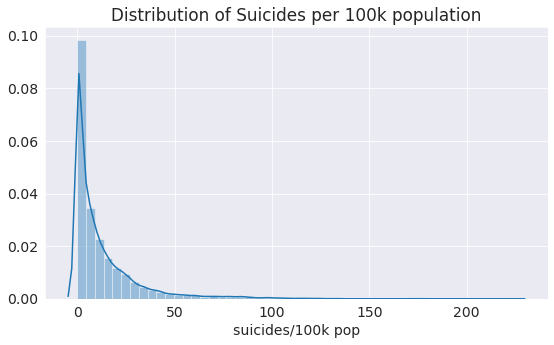

In [14]:
plt.title("Distribution of Suicides per 100k population")
sns.distplot(dataframe['suicides/100k pop']);

### Q: What are the minimum, average, and maximum suicide rates?

In [15]:
print("Minimum Suicides per 100k Population: {}".format(dataframe['suicides/100k pop'].min()))
print("Maximum Suicides per 100k Population: {}".format(dataframe['suicides/100k pop'].max()))
print("Average Suicides per 100k Population: {}".format(dataframe['suicides/100k pop'].mean()))

Minimum Suicides per 100k Population: 0.0
Maximum Suicides per 100k Population: 224.97
Average Suicides per 100k Population: 12.816097411933894


In [45]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/khalilhijazi/02-custom-sucide-linear-regression


<IPython.core.display.Javascript object>

## Step 3: Preparing the Dataset for Training

We'll first begin by converting our Pandas dataframe to a series of numpy arrays. The numeric features will be directly converted to numpy arrays. Categorical features, however, need to be transferred to an appropriate representation. We can do such a transformation by converting the categorical features to dummy binary predictor variables that specify which value of the fixed set of values for that feature is present at a given row entry.

In [17]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    temp = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        temp[col] = pd.get_dummies(temp[col])
    
    # Extract input & outputs as numpy arrays
    inputs_array = temp[input_cols].to_numpy()
    targets_array = temp[output_cols].to_numpy()
    return inputs_array, targets_array

In [18]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[1.00000000e+00, 1.98700000e+03, 0.00000000e+00, ...,
         2.15662490e+09, 7.96000000e+02, 0.00000000e+00],
        [1.00000000e+00, 1.98700000e+03, 0.00000000e+00, ...,
         2.15662490e+09, 7.96000000e+02, 0.00000000e+00],
        [1.00000000e+00, 1.98700000e+03, 1.00000000e+00, ...,
         2.15662490e+09, 7.96000000e+02, 0.00000000e+00],
        ...,
        [0.00000000e+00, 2.01400000e+03, 0.00000000e+00, ...,
         6.30670772e+10, 2.30900000e+03, 0.00000000e+00],
        [0.00000000e+00, 2.01400000e+03, 1.00000000e+00, ...,
         6.30670772e+10, 2.30900000e+03, 0.00000000e+00],
        [0.00000000e+00, 2.01400000e+03, 1.00000000e+00, ...,
         6.30670772e+10, 2.30900000e+03, 1.00000000e+00]]),
 array([[6.71],
        [5.19],
        [4.83],
        ...,
        [2.17],
        [1.67],
        [1.46]]))

Now that we've converted our inputs and targets to numpy arrays, it's time to convert them to PyTorch tensors.

In [19]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

Let's check the types to make sure that they're of type float32.

In [20]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we'll create our dataset and dataloaders that are needed for training and testing.

In [21]:
dataset = TensorDataset(inputs, targets)

Here, we tweak the percentage of the data owned by each of the training, validation, and testing sets. Then, we randomly split these datasets so that the order of the original data does not have any impact on the results.

In [22]:
val_percent = 0.15
test_percent = 0.15
val_size = int(num_rows * val_percent)
test_size = int(num_rows * test_percent)
train_size = num_rows - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size]) # randomly splitting the dataset into train, validation, and test datasets

Batch size is something important in a network. The larger the batch size is, the closer our mini-batch stochastic gradient descent results become relative to a full stochastic gradient descent on the entire data. The reason why we operate on batches is to improve speed, but in return we sacrifice a bit of accuracy in our model for that performance gain. Hence, the larger our batch size is, the more accurate, yet slow learning, our network becomes.

In [23]:
batch_size = 32

In this step, the dataloaders are created. It is important to understand why the training loader is shuffled while the validation and test loaders aren't. The reasoning behind this approach is that we would not like our model to learn based on the order of the data that is being fed to it because that will bias the model's understanding of the data towards a very specific direction, which is clearly something we don't want. But why don't we shuffle the other loaders? The reason why this is so is because when testing and validating, we really do not care about the order of elements we're evaluating our model against; all that really matters is how our model performs, which won't be any different based on order of the data.

In [24]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

Let's take a quick look at what one of our batches looks like.

In [25]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[0.0000e+00, 2.0000e+03, 1.0000e+00, 0.0000e+00, 2.3810e+05, 8.1900e-01,
         9.5834e+10, 3.1446e+04, 0.0000e+00],
        [0.0000e+00, 2.0000e+03, 1.0000e+00, 0.0000e+00, 1.1530e+06, 7.6900e-01,
         4.7311e+10, 4.9660e+03, 0.0000e+00],
        [0.0000e+00, 1.9860e+03, 1.0000e+00, 0.0000e+00, 2.2784e+06, 7.7660e-01,
         3.7744e+11, 1.6062e+04, 1.0000e+00],
        [0.0000e+00, 1.9930e+03, 1.0000e+00, 1.0000e+00, 7.1380e+05, 7.7660e-01,
         1.6281e+10, 1.6890e+03, 0.0000e+00],
        [0.0000e+00, 2.0040e+03, 1.0000e+00, 1.0000e+00, 4.2841e+05, 7.7660e-01,
         3.9416e+11, 5.6123e+04, 0.0000e+00],
        [0.0000e+00, 1.9980e+03, 1.0000e+00, 0.0000e+00, 1.7762e+05, 7.7660e-01,
         1.3617e+10, 4.0460e+03, 0.0000e+00],
        [0.0000e+00, 2.0010e+03, 1.0000e+00, 0.0000e+00, 2.6186e+06, 7.7660e-01,
         7.3638e+11, 2.5165e+04, 0.0000e+00],
        [0.0000e+00, 1.9950e+03, 0.0000e+00, 0.0000e+00, 3.4223e+05, 5.1300e-01,
         1.4655e+10, 1

In [39]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/khalilhijazi/02-custom-sucide-linear-regression


<IPython.core.display.Javascript object>

## Step 4: Creating a Linear Regression Model

Input size and output size are quite boring in that they're already predetermined based on your dataset and what features and labels you choose to use. What's really interesting is the size of the hidden layer (i.e. how many nodes the neural network has at a specific hidden layer). There's a lot of theories on how to go about choosing the right size for a hidden layer and more importantly for the network as a whole, but at the end of the day, most of this ends up being systematic experimentation and seeing what works best. There's generally a common rule of thumb to have the hidden size be anywhere between the input and output size, but sometimes that isn't the best choice for the model. That being said, I've experimented with this and found setting the hidden size to be the average between the input and output sizes worked well enough for this model.

In [27]:
input_size = len(input_cols)
output_size = len(output_cols)
hidden_size = (input_size + output_size) // 2
input_size, hidden_size, output_size

(9, 5, 1)

In this model, I create one hidden layer between the input and output layers. I also introduce the use of the ReLu function (f(x) = max(0, x)), which helps introduce nonlinearity to the model. Without the use of the ReLu function, this model would at best model a linear trend in the data, which isn't always the case. As for the loss function, I've chosen to use the l1 loss function over the mean squared error (MSE) loss function mainly because l1 loss performs much better when there are a lot of outliers in the data. When outliers are present, MSE loss tends to grow really fast due to the rapid growth of the parabolic curve it is built upon.

In [28]:
class SuicideRateModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) # hidden layer
        self.linear2 = nn.Linear(hidden_size, output_size) # output layer
    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)
        return loss
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch + 1) % 20 == 0 or epoch == num_epochs - 1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let's now create a model using the SuicideRateModel class.

In [29]:
model = SuicideRateModel()

We can immediately see that the PyTorch library has by default initialized our model parameters (the weights and biases) to random values. These will be refactored during training as our model learns more about the data.

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2607, -0.2693, -0.2301, -0.1531,  0.2703, -0.3152, -0.3206,  0.1158,
          -0.0906],
         [-0.2637,  0.0913, -0.0701, -0.0588,  0.0740, -0.1077,  0.2253, -0.3285,
          -0.3154],
         [-0.1985, -0.1436,  0.2089, -0.2217, -0.1528,  0.2176,  0.2821, -0.1974,
           0.3311],
         [-0.3266, -0.1124,  0.2101, -0.2125, -0.2752,  0.0953,  0.1409, -0.2400,
          -0.1781],
         [ 0.2929, -0.1546, -0.1049,  0.1768,  0.0744, -0.0672, -0.2633, -0.2822,
          -0.2366]], requires_grad=True),
 Parameter containing:
 tensor([-0.0661, -0.1228, -0.0380, -0.1720,  0.3211], requires_grad=True),
 Parameter containing:
 tensor([[0.0549, 0.2363, 0.1551, 0.2776, 0.0373]], requires_grad=True),
 Parameter containing:
 tensor([0.4126], requires_grad=True)]

In [31]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/khalilhijazi/02-custom-sucide-linear-regression


<IPython.core.display.Javascript object>

## Step 5: Training the Model to Fit the Data

We'll be using the fit function to train the model and the evaluate function to check how well our model is performing at each step.

In [32]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    training_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        training_history.append(evaluate(model, train_loader))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history, training_history

Let's quickly use the evaluate function to test our model with the randomly initialized parameters against the validation set before performing any training steps.

In [33]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 59966304256.0}


We're now ready to train our model. This process requires a significant amount of experimentation in terms of tuning the learning rate and number of epochs. There is some quite deep mathematical theory behind the values that do get chosen, and that requires understanding of gradient descent and how calculus works. Essentially, the dumbed down idea is that our goal is to minimize our model's loss function, which is differentiable on our model's parameters (i.e. the weights and biases). Let's imagine a random loss value output from our loss function. If the slope at that point is positive, then the loss function is increasing relative to that position. That means that to decrease the loss, we need to decrease our parameters by subtracting a small proportion of the positive slope value from them. Similarly, if the slope at that point is negative, then the loss function is decreasing relative to that position. This means that to decrease the loss further, we need to increase our parameters by subtracting (yes, subtracting!) from them a small proportion of the negative slope value. This small proportion is what's known as the learning rate. Having a large learning rate allows the model to learn really fast whereas a smaller learning rate forces the model to learn slowly. However, each learning rate option comes with its own drawbacks. High learning rates can cause the model to overshoot and miss the global minima whereas small learning rates can cause the model to undershoot and get suck at a local minima that may not be optimal. Hence, what tends to be the most logical strategy usually is to start at a high learning rate at first and then start lowering that learning rate such that the model approaches the global minima fast initially and then as it gets closer to the global minima, it slows down the learning rate so as not to overshoot the global minima. 

Epoch [5], val_loss: 10.8362


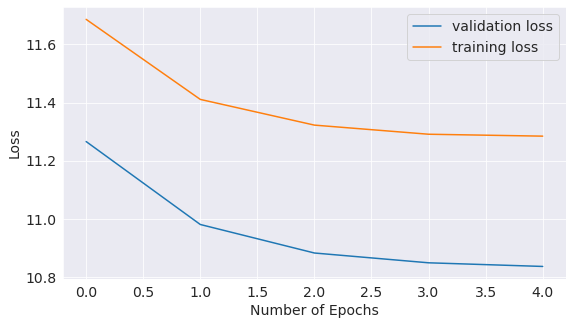

In [34]:
epochs = 5
lr = 1e-1
history1, training_history = fit(epochs, lr, model, train_loader, val_loader)
val_losses = []
training_losses = []

for obj in history1:
    val_losses.append(obj['val_loss'])
for obj in training_history:
    training_losses.append(obj['val_loss'])

plt.plot(val_losses, label='validation loss')
plt.plot(training_losses, label='training loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

From this graph, we can see that both our validation and training losses have dropped quite drastically in just 5 epochs. Let's see if we can decrease them further with a smaller learning rate.

Epoch [2], val_loss: 10.8362


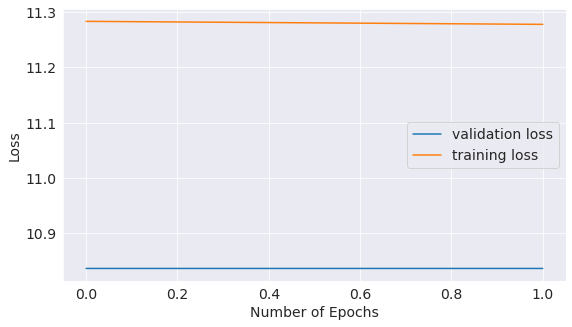

In [35]:
epochs = 2
lr = 1e-6
history2, training_history = fit(epochs, lr, model, train_loader, val_loader)
val_losses = []
training_losses = []

for obj in history2:
    val_losses.append(obj['val_loss'])
for obj in training_history:
    training_losses.append(obj['val_loss'])

plt.plot(val_losses, label='validation loss')
plt.plot(training_losses, label='training loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

It's quite apparent from the graph above that the losses have stalled and approached a flat curve. This essentially lets us know that our model has converged to what it thinks is the *optimum* solution. This can sometimes be inaccurate depending on the choices made for all the hyperparameters discussed earlier, but for this model, I've tested with multiple hyperparameters and the loss flattens out at this point regardless, so this stall in the loss is probably caused by the fact that our dataset is relatively small.

## Step 6: Evaluating the Model on the Test Data

Let's go right ahead and test out our model on the testing data to make sure that our testing loss is close enough to our training loss. If our testing loss is much larger than our training loss, that means our model has either overfit the training data by learning so many specific details about the training data that it cannot possibly generalize output to new, unseen data or underfit the training data by not learning enough aspects of the data to be able to make good predictions. If our testing loss is much lower than our training loss, then that means that either we made some mistake in our model construction or our testing data just contains much easier examples than our training data. But here's the catch! If it's the latter case and if the shuffling of the training data isn't based on an assigned random seed (i.e. training data order is same each time we run), then running multiple times should not produce the same loss comparison between the training and testing data. So if you do run multiple times and each time you get the testing loss much lower than the training loss, then there is a high likelihood that there's a logical error somewhere down the path of model construction.

In [36]:
result = evaluate(model, test_loader)
result

{'val_loss': 10.995272636413574}

Here, we can see that our testing loss is very close to our training loss, and thus, we haven't underfit nor overfit the training data. It looks like our model has performed just as we expected it to do so based on the output of the training steps above.

In [49]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/khalilhijazi/02-custom-sucide-linear-regression


<IPython.core.display.Javascript object>